In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import root_mean_squared_error, mean_squared_error, mean_absolute_error
from sklearn.feature_extraction import DictVectorizer
import pickle
import mlflow

In [2]:
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("nyc-taxi-experiment-automated")

2025/01/28 19:02:14 INFO mlflow.tracking.fluent: Experiment with name 'nyc-taxi-experiment-automated' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/125294369297097288', creation_time=1738087334544, experiment_id='125294369297097288', last_update_time=1738087334544, lifecycle_stage='active', name='nyc-taxi-experiment-automated', tags={}>

In [10]:
def prepare_the_data(url):
    df = pd.read_parquet(url)

    # Convert into minutes
    df['duration'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
    df['duration_minutes'] = df['duration'].dt.total_seconds() / 60

    # Filder df by trip time
    df = df[(df['duration_minutes'] >= 1) & (df['duration_minutes'] <= 60)]

    # Features defining
    categorical_features = ['PULocationID', 'DOLocationID']
    
    # Data Type preparation
    df[categorical_features] = df[categorical_features].astype(str)

    return df[:1000000]

In [6]:
def extract_features(df):
    features = df[['PULocationID', 'DOLocationID']]
    features_dict = features.to_dict(orient="records")

    # Fit a dictionary vectorizer
    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(features_dict)
    return X

In [9]:
def lr_training_batch(df, X, batch_size=10000):
    # Initialize the LinearRegression model
    lr = LinearRegression()
    y_true_all = []
    y_pred_all = []

    # Process data in batches
    for start in range(0, len(df), batch_size):
        batch = df.iloc[start:start + batch_size]
        y_true = batch['duration_minutes']
        
        # Select corresponding batch of features (X) based on the index range
        X_batch = X[start:start + batch_size]
        
        # Train on the current batch
        lr.fit(X_batch, y_true)

        # Predict and accumulate results
        y_pred_all.extend(lr.predict(X_batch))
        y_true_all.extend(y_true)

    # Calculate RMSE
    rmse = root_mean_squared_error(y_true_all, y_pred_all)

    # Save the model
    with open('models/lin_regression_automated.bin', 'wb') as f_out:
        pickle.dump(lr, f_out) 

    return rmse

In [11]:
with mlflow.start_run(run_name="lr-may-training"):
    tags = {"model": "LR", "developer": "Dmitry"}
    mlflow.set_tags(tags)
    mlflow.log_param("training_data_path", "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-05.parquet")
    
    df = prepare_the_data('https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-05.parquet')
    X = extract_features(df)
    error = lr_training_batch(df, X)
    
    mlflow.log_metric("rmse", error)

🏃 View run lr-may-training at: http://127.0.0.1:5000/#/experiments/125294369297097288/runs/ad00d0e877f44a5496bf4af4d1502ab5
🧪 View experiment at: http://127.0.0.1:5000/#/experiments/125294369297097288


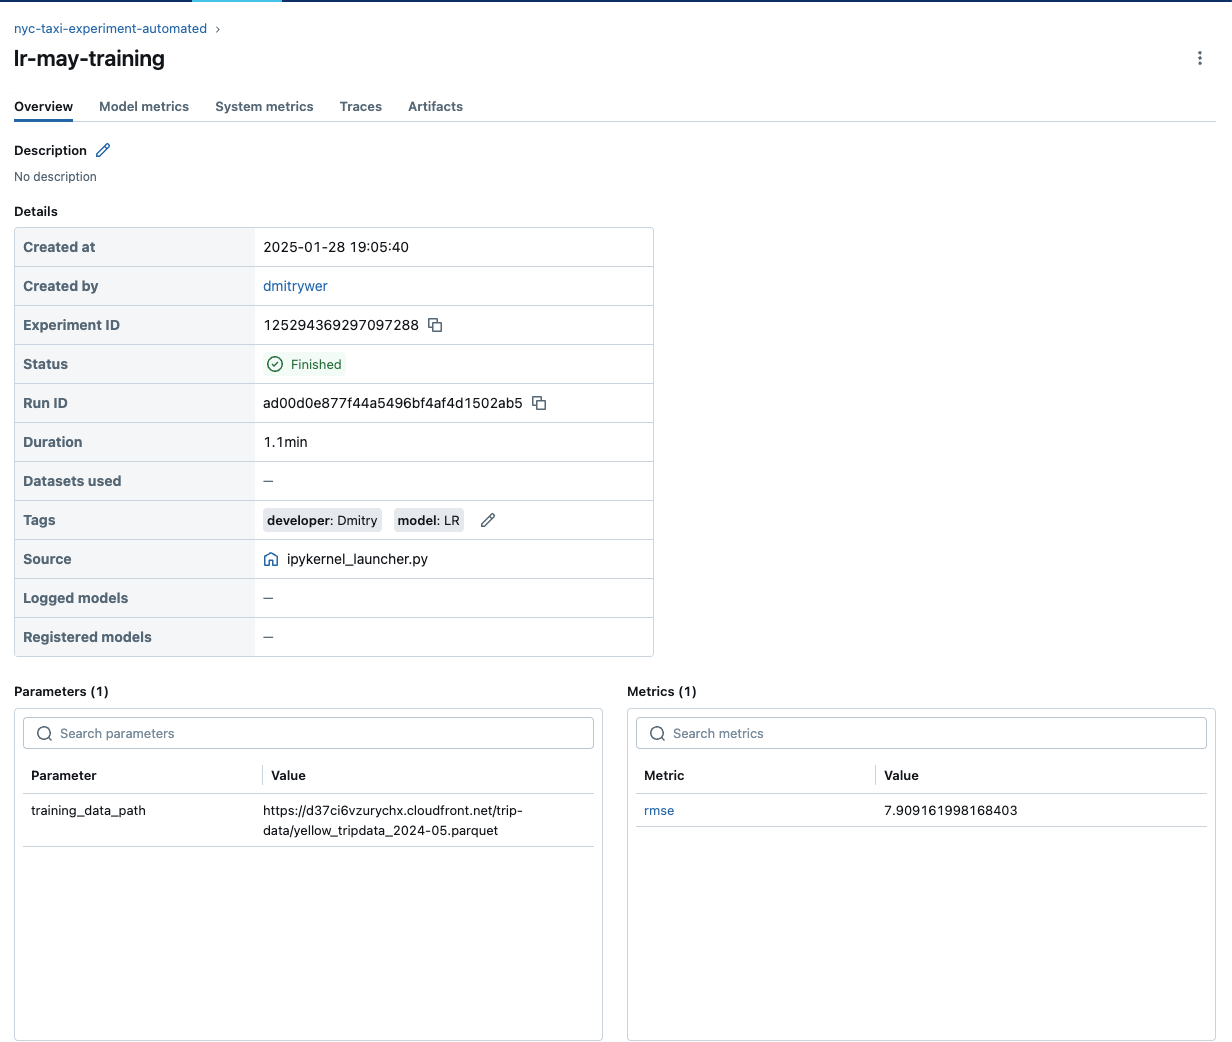